# Analysis of Sweep Results for Main Paper

### Imports:

In [1]:
from analysis_utils import rerun_trials, load_checkpoints, batched_cov_and_pcs
import numpy as np
import torch
from torch import nn
import neurogym as ngym
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 15
BIGGEST_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(f'<h4>{string}</h4>'))

def printbigmd(string):
    display(Markdown(f'<h2><center style="color:red">{string}</center></h2>'))

/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [2]:
def plot_stacked(series, space = 4, ytick = None):
    # series should be shape [Tsteps, Count].
    # Will stack these vertically in a plot. 
    spacing = np.cumsum(space*series.std(axis=0))
    spacing = np.pad(spacing, (1, 0))[:-1] # Put a zero at start.
    middles = spacing + series.mean(axis=0)
    stacked = series + spacing[None, :]

    plt.plot(stacked)
    if ytick is not None:
        plt.yticks(ticks = middles, labels = ytick)
    plt.xlabel('Time, t')

# A list of tasks I got decent accuracy on:
tasks_decent_acc = 'PerceptualDecisionMaking-v0 OneTwoThreeGo-v0 MultiSensoryIntegration-v0 MotorTiming-v0 IntervalDiscrimination-v0 GoNogo-v0 DelayPairedAssociation-v0 DelayComparison-v0 ContextDecisionMaking-v0'
tasks_decent_acc = tasks_decent_acc.split() # str -> list of str.


### Set the root directory of data to analyze. <strong>User should customize:</strong>

In [3]:
neurogym_root = '/home/ws3/Desktop/james/neurogym/examples/'
task = tasks_decent_acc[1]
root = neurogym_root + task + '/'
printbigmd(f'Data root file: {root}')

<h2><center style="color:red">Data root file: /home/ws3/Desktop/james/neurogym/examples/OneTwoThreeGo-v0/</center></h2>

In [4]:
checkpoints, GD_iteration = load_checkpoints(root)
checkpoints, GD_iteration = checkpoints[::10], GD_iteration[::10]
printbigmd(f'{len(checkpoints)} Checkpoints, over {GD_iteration[-1]} GD iterations')

<h2><center style="color:red">10 Checkpoints, over 18000 GD iterations</center></h2>

## Analysis Begins...

#### Define the task inputs and targets. These will be consistently used for all reruns:

In [5]:
def load_task(task, ntrials = 2560):
    kwargs = {'dt': 100}
    seq_len = 100
    dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=ntrials, seq_len=seq_len)

    inputs, labels = dataset()
    inputs, labels = inputs.swapaxes(0,1), labels.swapaxes(0,1)
    targets = nn.functional.one_hot(torch.from_numpy(labels)).numpy()
    return inputs, labels, targets
inputs, labels, targets = load_task(task)
printmd(f'Input size [B, T, n_in]: {inputs.shape}, Target size [B, T, n_out]: {targets.shape}')

/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


<h4>Input size [B, T, n_in]: (2560, 100, 3), Target size [B, T, n_out]: (2560, 100, 2)</h4>

#### Rerun all checkpoint models on these data:

In [6]:
zs_all, adjs_all, outs_all, losses_all = rerun_trials(inputs, targets, checkpoints, compute_adj = True, device='cpu')
printmd(f'zs shape is [checkpoints, trials, timesteps, n_hidden]: {zs_all.shape}')

Re-evaluating on the Same Data.


/home/ws3/Desktop/james/neurogym/examples/OneTwoThreeGo-v0/checkpoints/checkpoint_18000.pt: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


<h4>zs shape is [checkpoints, trials, timesteps, n_hidden]: (10, 2560, 100, 128)</h4>

### Analysis of Model Performance:

/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/matplotlib_inline/config.py:59: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


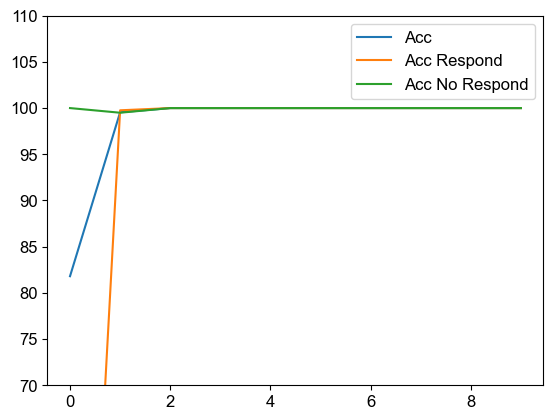

In [7]:
def acc_measures(outs, labels):
    out_labels = np.argmax(outs, axis = -1)
    base_acc = (out_labels == labels).mean() # Responses overall.
    acc_response = (out_labels == labels)[labels != 0].mean() # Responses when the model should be responding.
    acc_no_respond = (out_labels == labels)[labels == 0].mean() # Responses when model shouldn't respond at all.
    return base_acc, acc_response, acc_no_respond

accs = []
for out in outs_all:
    accs.append(list(acc_measures(out, labels)))
accs = np.array(accs)

# plt.yscale('log')
plt.plot(accs*100)
plt.ylim(70, 110)

plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())

plt.legend(['Acc', 'Acc Respond', 'Acc No Respond'])
plt.show()

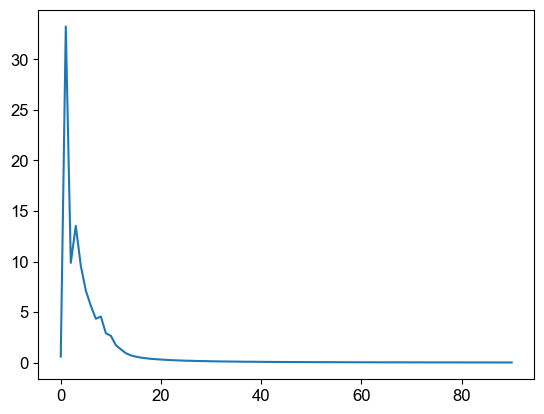

In [8]:
plt.plot(torch.load(checkpoints[-1], weights_only=True)['losses'])
plt.show()

Shape of inputs, targets, labels, hidden:  (2560, 100, 3) (2560, 100, 2) (2560, 100) (10, 2560, 100, 128)


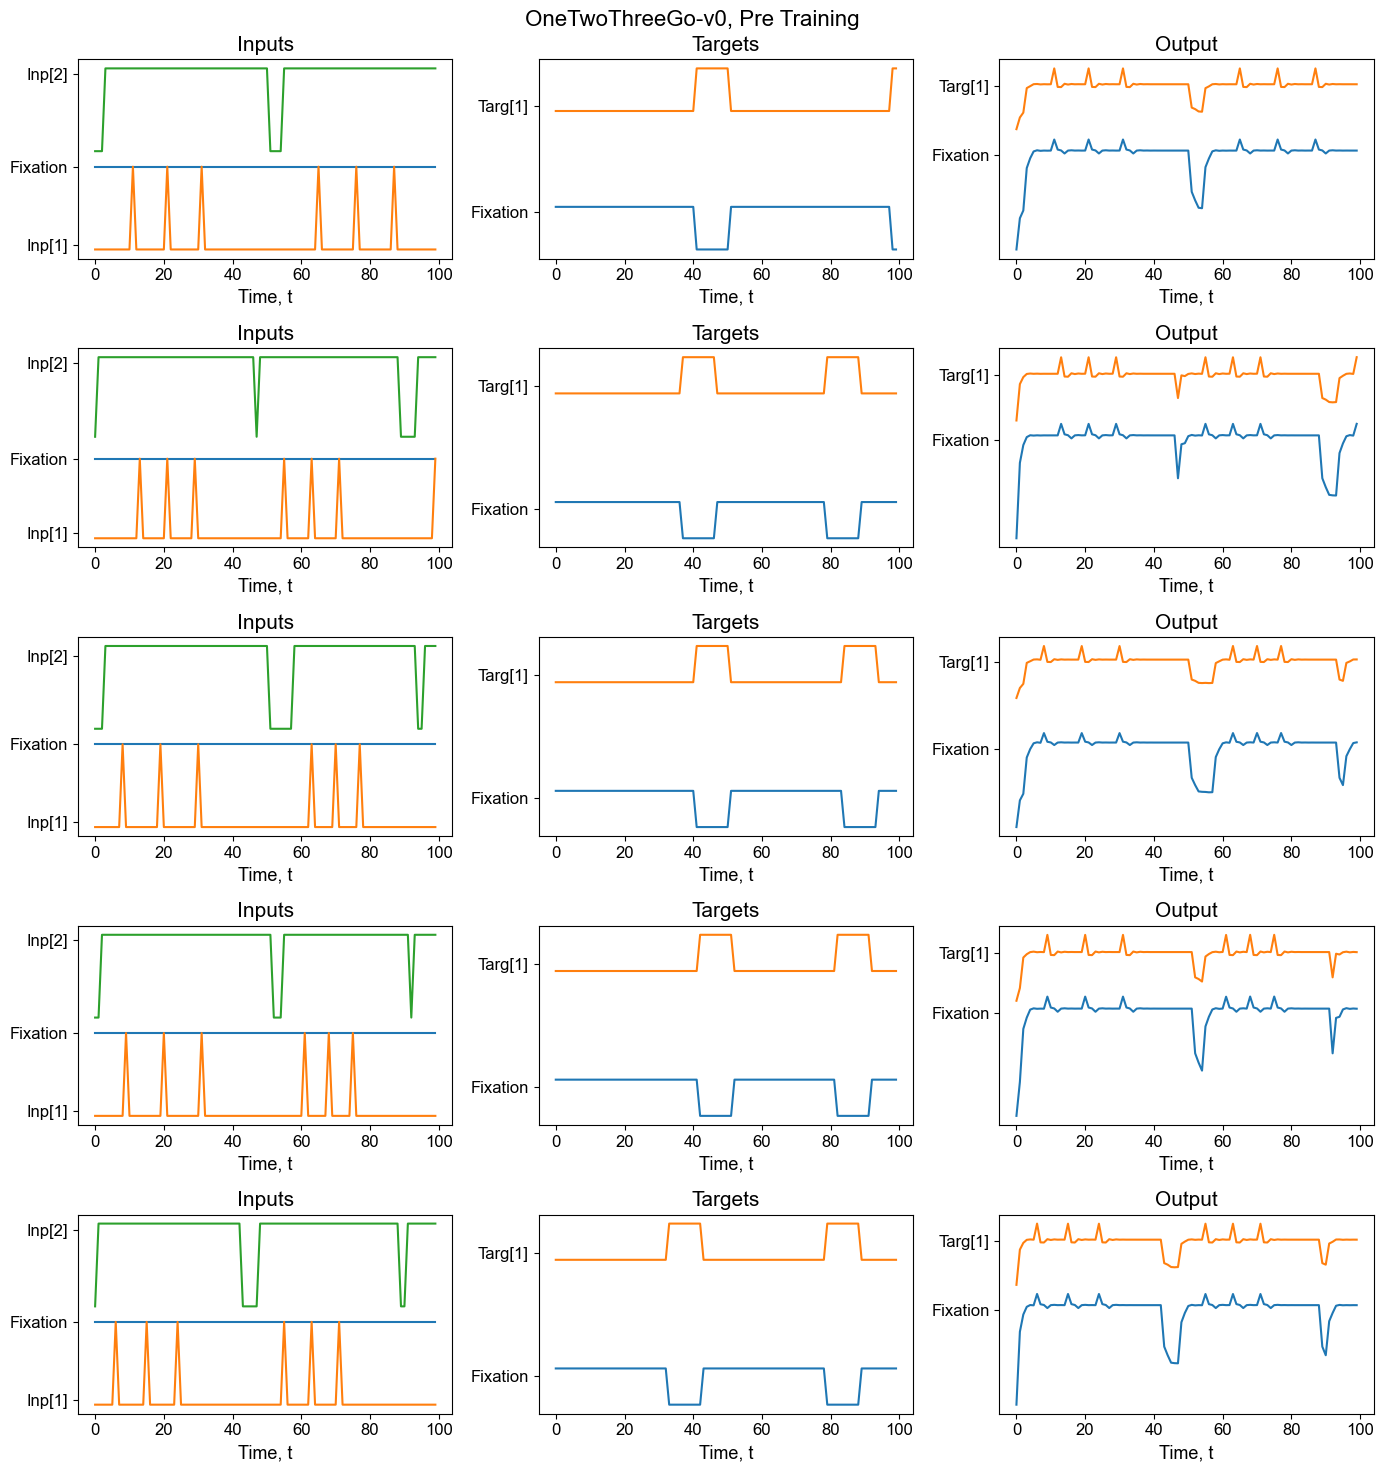

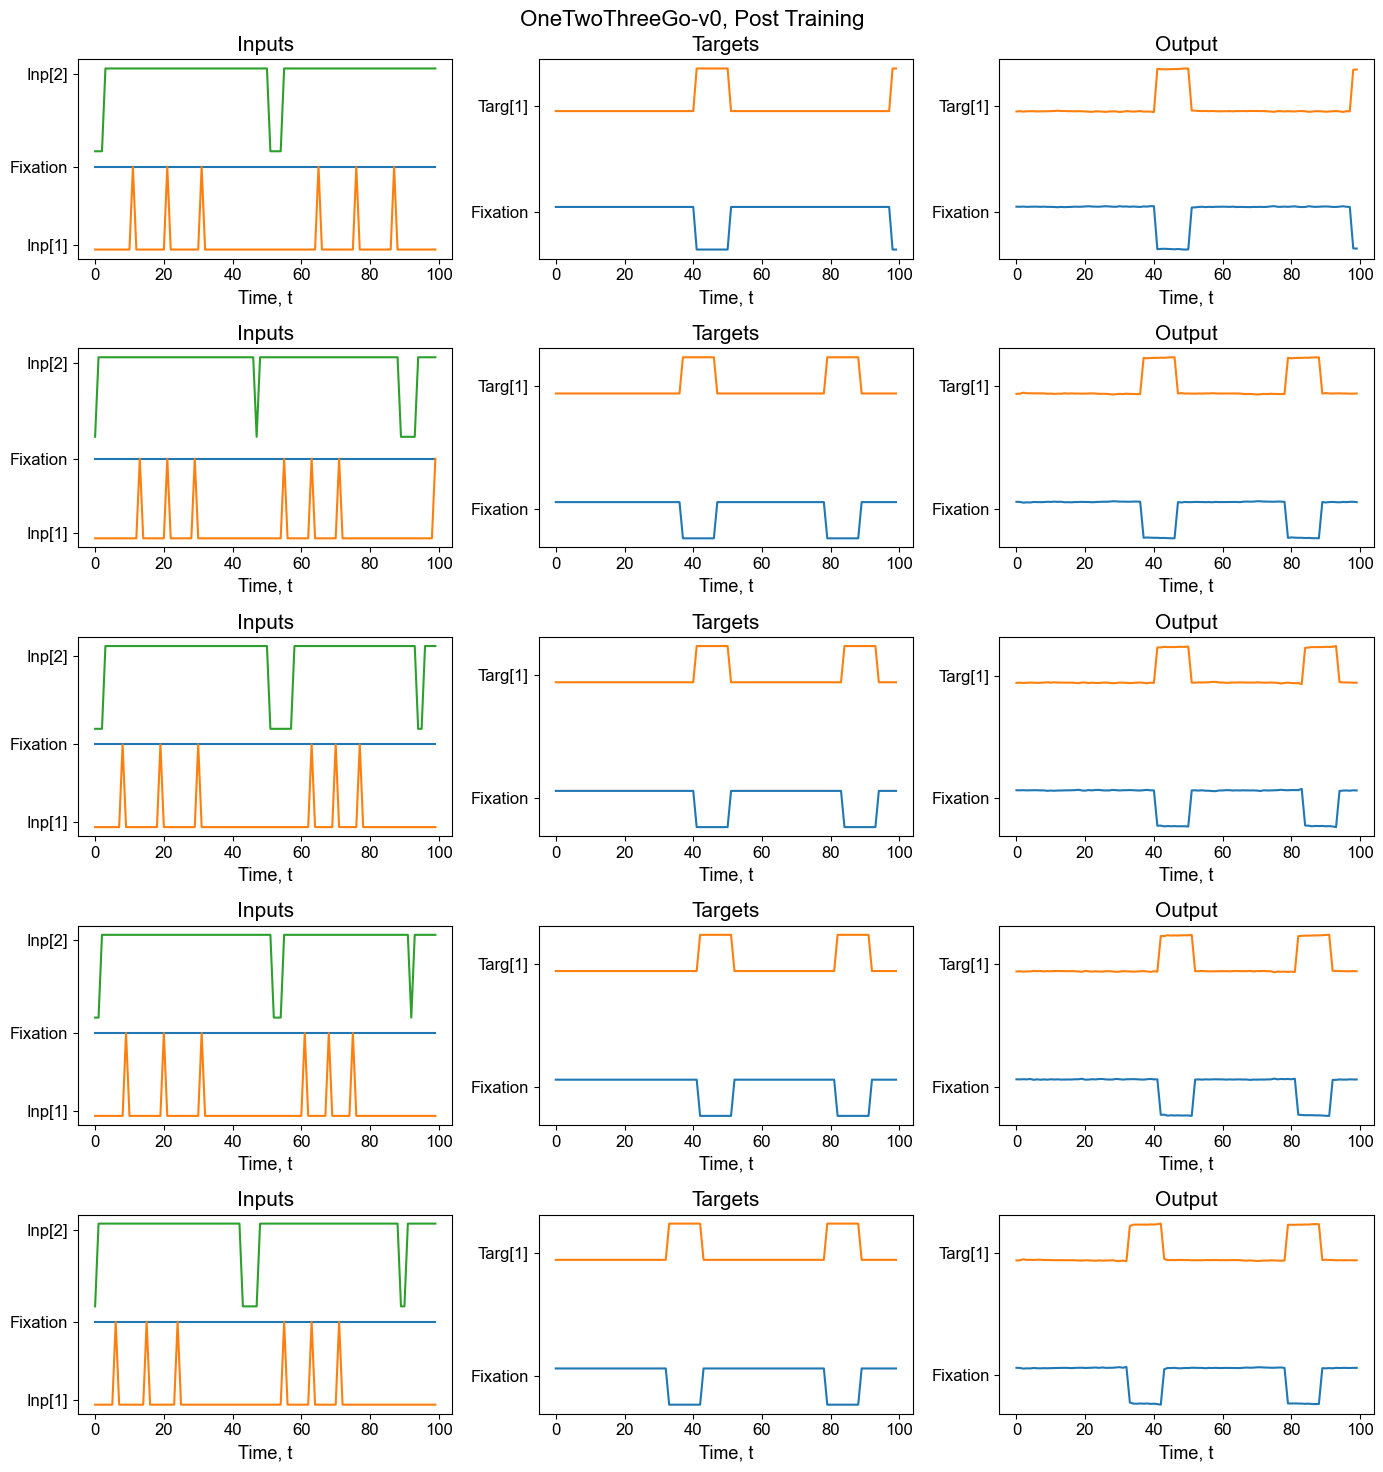

In [9]:
print("Shape of inputs, targets, labels, hidden: ", inputs.shape, targets.shape, labels.shape, zs_all.shape) # Helps me to check shapes :)


for gd_itr  in [0, -1]:
    plt.figure(figsize = (14, 3*5))
    for b in range(5):
        plt.subplot(5,3,1+3*b)
        plt.title('Inputs')
        plot_stacked(inputs[b, :, :], space = 5, ytick = ['Fixation'] + [f'Inp[{i}]' for i in range(1,inputs.shape[-1])])
        plt.subplot(5,3,2+3*b)
        plt.title('Targets')
        plot_stacked(targets[b, :, :], space = 10, ytick = ['Fixation'] + [f'Targ[{i}]' for i in range(1,targets.shape[-1])])
        plt.tight_layout()
        plt.subplot(5,3,3+3*b)
        plt.title('Output')
        plot_stacked(outs_all[gd_itr, b, :, :], space = 10, ytick = ['Fixation'] + [f'Targ[{i}]' for i in range(1,targets.shape[-1])])

    plt.suptitle(f'{task}, {"Post Training" if gd_itr == -1 else "Pre Training"}')
    plt.tight_layout()
    plt.show()

##### Plot Output Over GD:

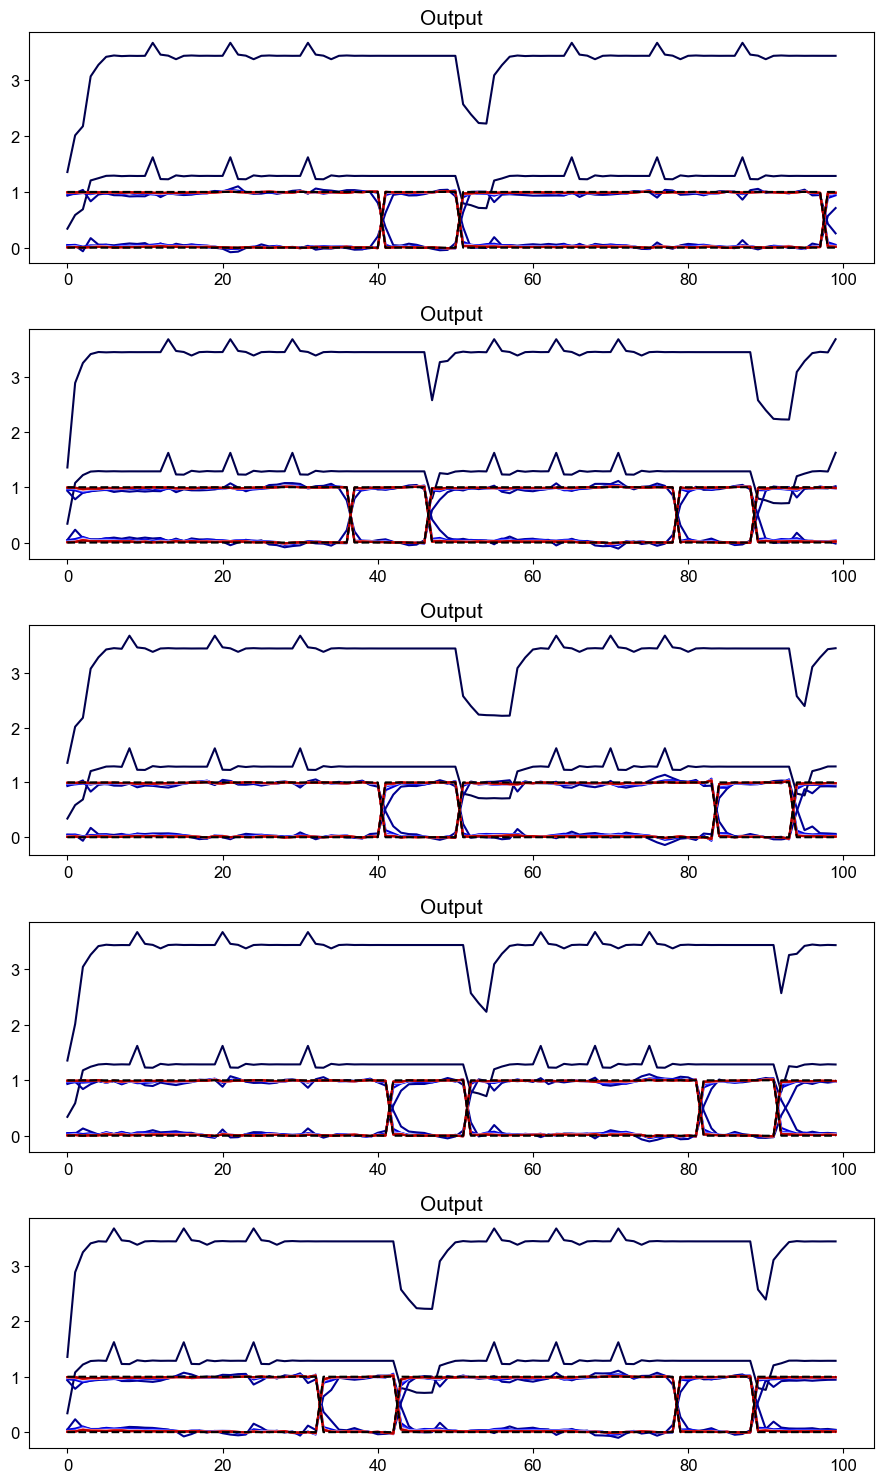

In [10]:
cmap = plt.get_cmap('seismic')
plt.figure(figsize = (9, 3*5))
ngd = outs_all.shape[0]
for b in range(5):
    for gd_itr  in range(ngd):
        plt.subplot(5,1,1+b)
        plt.title('Output')
        plt.plot(outs_all[gd_itr, b, :, :], color = cmap(gd_itr / ngd), zorder = 1)
    plt.plot(targets[b, :, :], color = 'black', linestyle = 'dashed', zorder = 10)

plt.tight_layout()
plt.show()

### Covariance Analysis for PCA: 

In [11]:
# Normalize scales.
zs_all_nm, adjs_all_nm = zs_all / np.mean(np.abs(zs_all)), adjs_all / np.mean(np.abs(adjs_all))

<>:22: DeprecationWarning: invalid escape sequence '\l'
/home/ws3/Desktop/james/adjoint_dynamics/analysis_utils.py:94: RuntimeWarning: invalid value encountered in divide
  variance_ratios = np.cumsum(evals / total_variances[..., None], axis = -1)


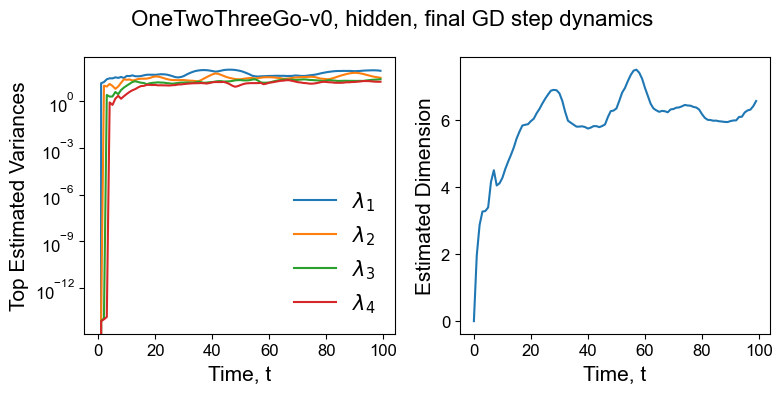

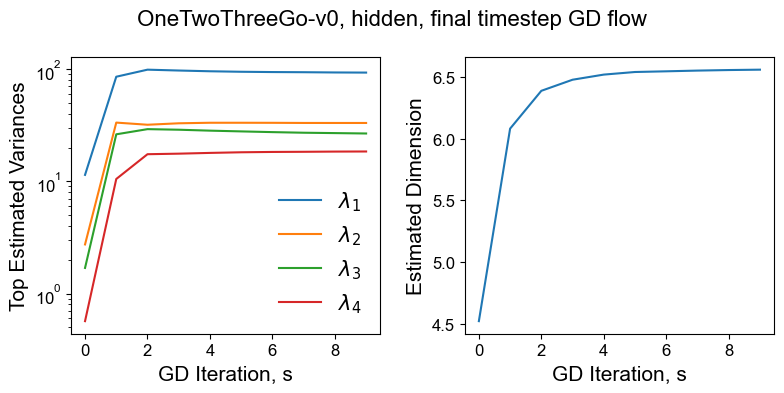

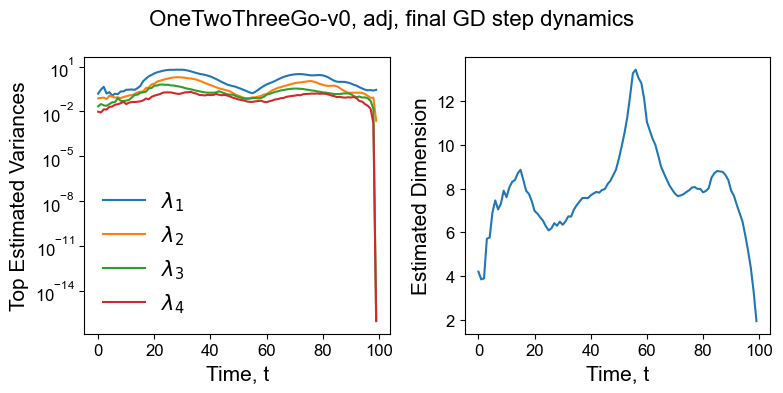

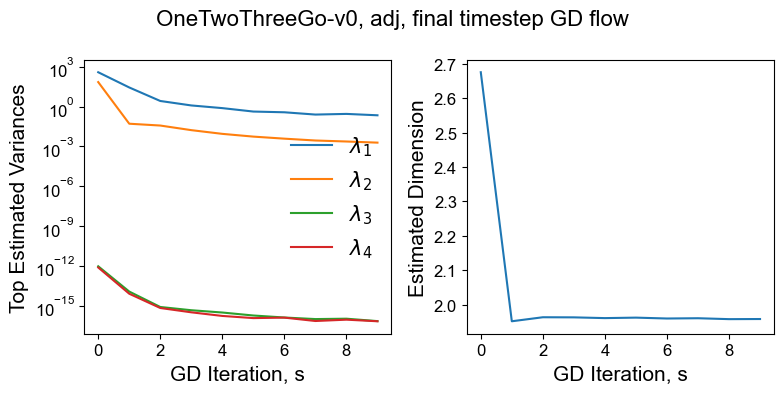

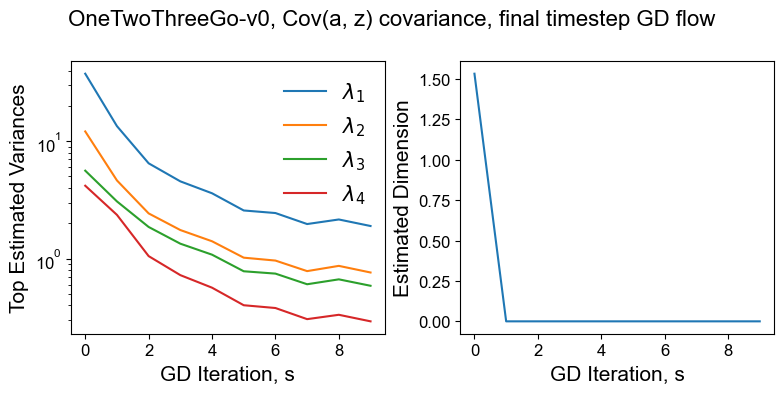

In [12]:
plot_spec = [
    {'traj': zs_all_nm[-2:-1], 'title': f'{task}, hidden, final GD step dynamics', 'xlabel': 'Time, t', 'smoothing': 1},
    {'traj': zs_all_nm[:, :, -1:].swapaxes(0,2), 'title': f'{task}, hidden, final timestep GD flow', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    {'traj': adjs_all_nm[-2:-1], 'title': f'{task}, adj, final GD step dynamics', 'xlabel': 'Time, t', 'smoothing': 1},
    {'traj': adjs_all_nm[:, :, -1:].swapaxes(0,2), 'title': f'{task}, adj, final timestep GD flow', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    {'traj': zs_all_nm[:, :, -1:].swapaxes(0,2), 'traj2': adjs_all_nm[:, :, -1:].swapaxes(0,2), 'title': f'{task}, Cov(a, z) covariance, final timestep GD flow', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
]

def smooth(y, box_pts, mode = 'same'):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def plot_dimensions(spec):
    traj, title, xlabel, smoothing = spec['traj'], spec['title'], spec['xlabel'], spec['smoothing']
    traj2 = spec.get('traj2', None)
    covs, evals, pcs, variance_ratios, dims = batched_cov_and_pcs(traj, traj2)

    plt.figure(figsize = (8, 4))
    plt.subplot(1,2,1)
    for ev_idx in range(min(evals.shape[2], 4)):
        plt.plot(evals[0, :, ev_idx], label  = f'$\lambda_{ev_idx+1}$')
    plt.ylabel('Top Estimated Variances', fontsize = 15)
    plt.yscale('log')
    plt.xlabel(xlabel, fontsize = 15)
    plt.legend(frameon=False, fontsize = 15)

    plt.subplot(1,2,2)
    plt.xlabel(xlabel, fontsize = 15) 
    plt.ylabel('Estimated Dimension', fontsize = 15)
    dim_smooth = smooth(dims[0], smoothing, mode = 'valid')
    plt.plot(dim_smooth)
    # if 'xmax' in spec:
    #   plt.xlim(0, spec['xmax'])
    plt.suptitle(title, fontsize = 16)
    plt.tight_layout()
    plt.show()

for spec in plot_spec:
    plot_dimensions(spec)

### Analysis of GD Changes

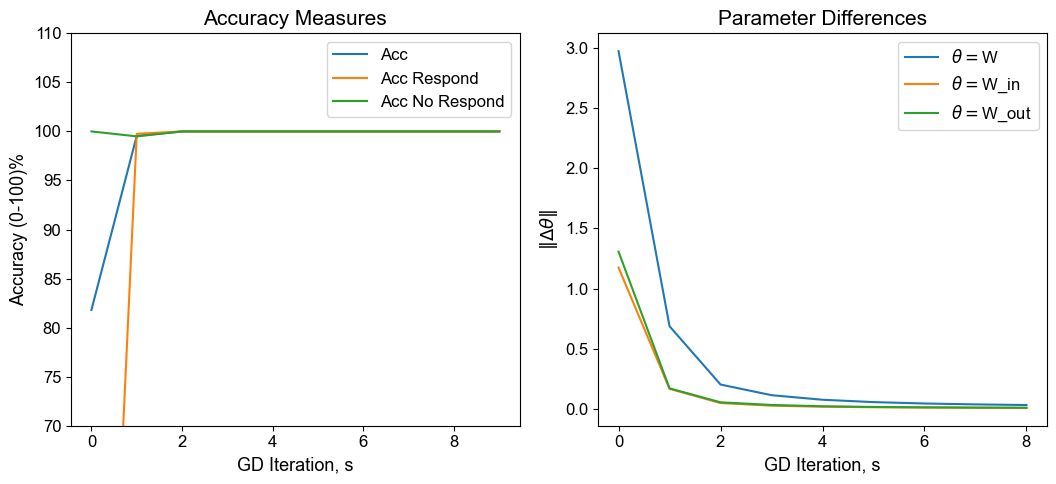

In [13]:
models = [torch.load(ch, map_location = 'cpu', weights_only = True)['model'] for ch in checkpoints]

def extract(key):
    return np.array([model[f'{key}.weight'].detach().numpy() for model in models])

param_gd_flow = {'W':extract('W'), 'W_in':extract('W_in'), 'W_out':extract('W_out')}

plt.figure(figsize = (16, 5))
plt.subplot(1,3,1)
# plt.yscale('log')
plt.plot(accs*100)
plt.ylim(70, 110)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.legend(['Acc', 'Acc Respond', 'Acc No Respond'])
plt.ylabel('Accuracy (0-100)%')
plt.xlabel('GD Iteration, s')
plt.title('Accuracy Measures')

plt.subplot(1,3,2)
for key,val in param_gd_flow.items():
    norm_gd_flow = np.linalg.norm(val[1:] - val[:-1], axis = (1, 2))
    plt.plot(norm_gd_flow, label = f'$\\theta = ${key}')
plt.legend()
# plt.yscale('log')
plt.title('Parameter Differences')
plt.xlabel('GD Iteration, s')
plt.ylabel('$\\|\\Delta \\theta\\|$')
plt.tight_layout()
plt.show()

# Scale Analysis:

### Next, look at scale of init. How does hidden dimension evolve based on input dimension. How does scale affect this?

In [14]:
def get_scaled_models(model0, gs, just_scale_W = False):
    import copy
    sweep_models = [copy.deepcopy(model0) for i in range(len(gs))]
    for g, scaled_model in zip(gs, sweep_models):
        scaled_model['W.weight'] *= g
        if not just_scale_W:
            scaled_model['W_in.weight'] *= g
            scaled_model['W_out.weight'] *= g
    return sweep_models # List of state dicts

Re-evaluating on the Same Data.


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


<h4>zs scale sweep shape is [checkpoints, trials, timesteps, n_hidden]: (3, 2560, 100, 128)</h4>

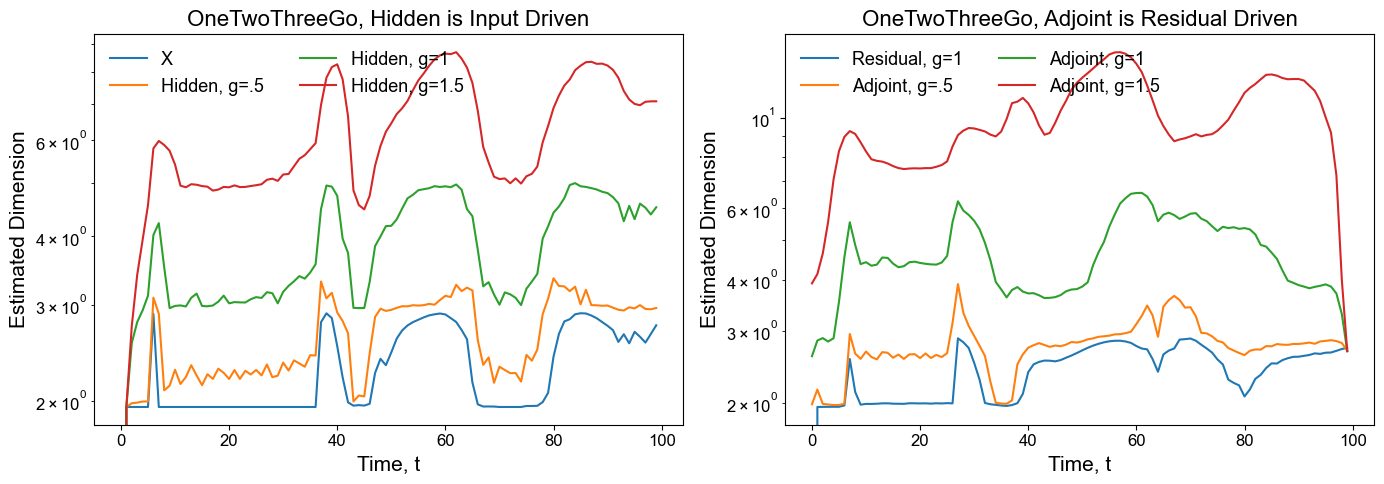

In [38]:
sweep_models = get_scaled_models(models[0], [.5, 1., 1.5], just_scale_W = True)
zs_scales, adjs_scales, outs_scales, losses_scales = rerun_trials(inputs, targets, sweep_models, compute_adj = True, device='cpu')
adjs_scales_nm = adjs_scales / np.mean(np.abs(adjs_scales))
printmd(f'zs scale sweep shape is [checkpoints, trials, timesteps, n_hidden]: {zs_scales.shape}')

residuals_scales = outs_scales - targets[None] # This will drive adjoint for MSE loss. For other losses, different story.

zs_scales = [inputs] + list(zs_scales) # To list, concatenate inputs also. 
spec1 = {'traj': zs_scales, 'title': f'{task[:-3]}, Hidden is Input Driven', 'xlabel': 'Time, t', 'smoothing': 1}
adjs_scales_nm = [residuals_scales[1]] + list(adjs_scales_nm)
spec2 = {'traj': adjs_scales_nm, 'title': f'{task[:-3]}, Adjoint is Residual Driven', 'xlabel': 'Time, t', 'smoothing': 1}

def plot_dimensions_sweep(spec):
    traj_all, title, xlabel, smoothing = spec['traj'], spec['title'], spec['xlabel'], spec['smoothing']        
    for i in range(len(traj_all)):
        traj = traj_all[i][None]
        traj2 = None if 'traj2' not in spec else spec['traj2'][i][None]
    
        dims = batched_cov_and_pcs(traj, traj2)[-1]
        dim_smooth = smooth(dims[0], smoothing, mode = 'valid')
        plt.plot(dim_smooth)

    plt.xlabel(xlabel, fontsize = 15) 
    plt.ylabel('Estimated Dimension', fontsize = 15)
    plt.title(title, fontsize = 16)
    plt.tight_layout()

plt.figure(figsize = (14, 5))
plt.subplot(1,2,1)
plot_dimensions_sweep(spec1)
plt.legend(['X', 'Hidden, g=.5', 'Hidden, g=1', 'Hidden, g=1.5'], ncol=2, frameon=False, fontsize = 13)
plt.yscale('log')
# plt.tight_layout()
plt.subplot(1,2,2)
# plt.savefig('Dimension_scale.pdf')
# plt.figure(figsize = (10, 5))
plot_dimensions_sweep(spec2)
plt.legend(['Residual, g=1', 'Adjoint, g=.5', 'Adjoint, g=1', 'Adjoint, g=1.5'], ncol=2, frameon=False, fontsize = 13)
plt.yscale('log')
plt.tight_layout()
plt.savefig('Dimension_scale_all.pdf')
plt.show()

### To be more comprehensive, measure how the mean of the ratio of hidden dimension to input dimension grows with scale. Do this for many tasks. 

#### NOTE: this code will redefine task, inputs, labels, etc. So you need to rerun ALL of the above if you want to play with that. 

In [64]:
tasks_all = ['AntiReach-v0',
# 'Bandit-v0',
'ContextDecisionMaking-v0',
# 'DawTwoStep-v0',
'DelayComparison-v0',
'DelayMatchCategory-v0',
'DelayMatchSample-v0',
'DelayMatchSampleDistractor1D-v0',
'DelayPairedAssociation-v0',
'DualDelayMatchSample-v0',
# 'EconomicDecisionMaking-v0',
'GoNogo-v0',
'HierarchicalReasoning-v0',
'IntervalDiscrimination-v0',
'MotorTiming-v0',
'MultiSensoryIntegration-v0',
'OneTwoThreeGo-v0',
'PerceptualDecisionMaking-v0',
'PerceptualDecisionMakingDelayResponse-v0',
'PostDecisionWager-v0',
'ProbabilisticReasoning-v0',
'PulseDecisionMaking-v0',
'Reaching1D-v0',
'Reaching1DWithSelfDistraction-v0',
# 'ReachingDelayResponse-v0',
'ReadySetGo-v0',
'SingleContextDecisionMaking-v0'
]

In [79]:
from architecture import ModelRNNv3
gs = np.linspace(0., 2.5, 15)

zs_scales = [inputs] + [individual for individual in zs_scales] # To list, concatenate inputs also. 

ratios = []
for task in tqdm(tasks_all):
    inputs, labels, targets = load_task(task, ntrials = 2560)
    model0 = ModelRNNv3(n_hidden = 128, n_in = inputs.shape[-1], n_out = targets.shape[-1]).state_dict()
    sweep_models = get_scaled_models(model0, gs, just_scale_W = True)
    zs_scales = rerun_trials(inputs, targets, sweep_models, device='cpu', verbose = False)

    input_dim = batched_cov_and_pcs(inputs[None])[-1][0] # [tsteps]
    hidden_dims = batched_cov_and_pcs(zs_scales)[-1] # [len(gs), tsteps]
    rat = np.mean(hidden_dims,1) / np.mean(input_dim)
    ratios.append(rat)
ratios = np.stack(ratios)

  0%|          | 0/23 [00:00<?, ?it/s]/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/ws3/Desktop/james/adjoint_dynamics/analysis_utils.py:94: RuntimeWarning: invalid value encountered in divide
  variance_ratios = np.cumsum(evals / total_variances[..., None], axis = -1)
 78%|███████▊  | 18/23 [06:26<01:56, 23.37s/it]/tmp/ipykernel_1251/3279894

In [42]:

def condense_name(name):
    name = name[:-3] # Cut out -v0
    lower = lambda s: ''.join([s[0]] + [c for c in s[1:] if c.islower()])
    name = ''.join(lower(name[i:i+3]) for i, c in enumerate(name) if c.isupper())
    return name

plt.figure(figsize = (10, 6))
mask = ~np.isnan(ratios).any(axis=1)
ratios_clean = ratios[mask]


abbr_task_names = [condense_name(name) for name in tasks_all]
for idx, (rat, task_name) in enumerate(zip(ratios, abbr_task_names)):
    marker = '*' if idx >= 20 else ('x' if idx >= 10 else '^') # 10 distinct colors, so use different marker for every 10
    plt.scatter(gs, rat, label=task_name, marker = marker)


plt.legend(frameon=False, ncol=3, fontsize = 12)
plt.plot(gs, ratios_clean.mean(0))
plt.yscale('log')
plt.xlabel('Initialization Scale, $g$', fontsize = 15)
plt.ylabel('Hidden-Input Dimension Ratio', fontsize = 15)
plt.title('Hidden-Input Ratio Over Many Tasks')
plt.tight_layout()
plt.savefig('Dimension_ratios_tasks.pdf')
plt.show()

NameError: name 'ratios' is not defined

<Figure size 1000x600 with 0 Axes>

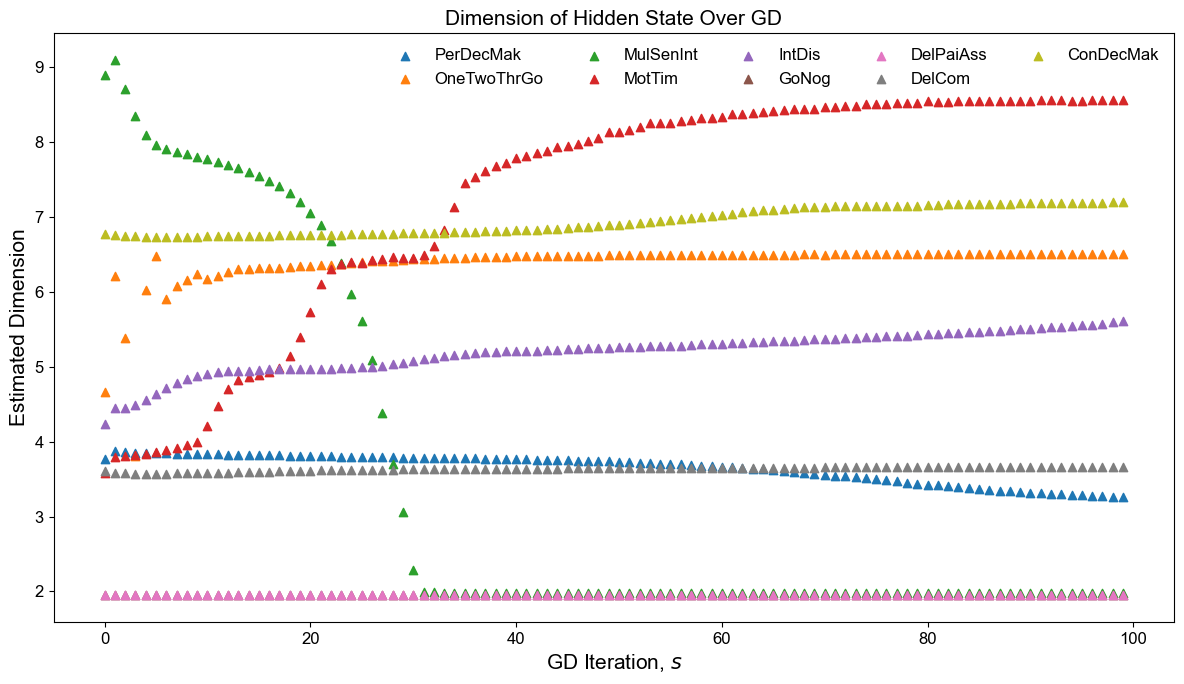

In [55]:
# Todo: put dim code here
dims_all = np.loadtxt('dims_all.csv')

plt.figure(figsize = (12, 7))

abbr_task_names = [condense_name(name) for name in tasks_decent_acc]
for idx, (dims, task_name) in enumerate(zip(dims_all, abbr_task_names)):
    marker = '*' if idx >= 20 else ('x' if idx >= 10 else '^') # 10 distinct colors, so use different marker for every 10
    plt.scatter(np.arange(len(dims)), dims, label=task_name, marker = marker)

plt.legend(frameon=False, ncol=5, fontsize = 12)
# plt.plot(dims_all.mean(0))
# plt.yscale('log')
plt.xlabel('GD Iteration, $s$', fontsize = 15)
plt.ylabel('Estimated Dimension', fontsize = 15)
plt.title('Dimension of Hidden State Over GD')
plt.tight_layout()
plt.savefig('Dimension_all_tasks.pdf')
plt.show()
